Lauren Eckert / Sentiment Analysis model

This data pipeline should take social media text, process it, and give the polarity of the text.

Sentiment analysis type: document based

In [1]:
#imports
import pandas as pd
import apify_client as Client
import os

## **1. Data Scraping**

### Using Apify API:
- Scrape Instagram posts using account URL.
    - Extract the last 100 posts.
    - Data to collect: Post captions, timestamps, likes, comment count, and URLs.
- Extract comments from posts using post URLs.
    - Options: Scrape top 50 comments per post.
    - Data to collect: Comment text, username, and timestamp.


In [2]:
# Initialize Apify Client
APIFY_API_TOKEN = "apify_api_zJZzovWdRQoy7zQFgGUo95wRB604rb3fp8xe"
client = Client.ApifyClient(APIFY_API_TOKEN)

In [3]:
# Functions
def run_scraper(actor_id, input_payload):
    try:
        run = client.actor(actor_id).call(run_input=input_payload)
        run_id = run.get("id")
        print(f"Scraper started. Run ID: {run_id}")
        return run
    except Exception as e:
        print(f"Error: {e}")
        raise

def fetch_data(run, sample_size=5):
    """
    Fetches the dataset from a completed scraper run and displays a sample of the data.
    
    Parameters:
    - run: The result of the run_scraper function (contains dataset info).
    - sample_size: The number of records to display as a sample.
    
    Returns:
    - A list of JSON objects representing the data.
    """
    dataset_id = run["defaultDatasetId"]
    
    # Fetch all items from the dataset
    data = []
    list_page = client.dataset(dataset_id).list_items()
    for item in list_page.items:
        data.append(item)
    
    # Display sample of the data
    print(f"Fetched {len(data)} records. Showing a sample of {sample_size}:")
    sample_data = data[:sample_size]  # Get a sample
    for i, record in enumerate(sample_data, start=1):
        print(f"\nSample {i}: {record}")
    
    return data

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Specific Scraper Helpers
def run_posts_scraper(profile_url, max_posts=100):
    input_payload = {
        "directUrls": [profile_url],  # Use direct URLs not a username
        "resultsType": "posts",       # Specify that I want posts
        "resultsLimit": max_posts,    # Limit the number of results
        "searchType": "user",         # Search type is user
        "addParentData": False        # Optionally include parent data
    }
    return run_scraper("apify/instagram-scraper", input_payload)

def run_comments_scraper(post_urls, max_comments=100):
    input_payload = {
        "directUrls": post_urls,
        "resultsLimit": max_comments
    }
    return run_scraper("apify/instagram-comment-scraper", input_payload)

def extract_comment_data(raw_comments):
    """
    Extracts relevant fields from raw Instagram comments data for preprocessing.
    
    Parameters:
    - raw_comments: A list of dictionaries, where each dictionary contains comment metadata.
    
    Returns:
    - A structured list of dictionaries with extracted fields.
    """
    extracted_data = []
    for comment in raw_comments:
        extracted_data.append({
            'postUrl': comment.get('postUrl'),
            'id': comment.get('id'),
            'text': comment.get('text'),
            'ownerUsername': comment.get('ownerUsername'),
            'timestamp': comment.get('timestamp'),
            'likesCount': comment.get('likesCount'),
            'repliesCount': comment.get('repliesCount'),
        })
    return extracted_data


In [4]:
# Run posts scraper

#profile_url  = "https://www.instagram.com/nycjewelryweek/"
profile_url = "https://www.instagram.com/chappellroan/"

#posts_run = run_posts_scraper(profile_url)

In [5]:
# Fetch posts data

#posts_data = fetch_data(posts_run)
#save_to_csv(posts_data, "instagram_posts_chappellroan_12_14.csv")

In [6]:
# Inspect the structure of posts_data

#print(posts_data[0])

# Extract post URLs for comments scraping
#post_urls = [post["url"] for post in posts_data]

# Run comments scraper
#comments_run = run_comments_scraper(post_urls, max_comments=100)

In [7]:
# Fetch comments data

#comments_data = fetch_data(comments_run)

# Extract relevant data
#structured_data = extract_comment_data(comments_data)
#comments_df = pd.DataFrame(structured_data)
#print(comments_df.sample(5))

In [8]:
#save_to_csv(comments_df, "instagram_comments_chappellroan_12_14.csv")


## **2. Loading Data**

- Data Format: Import the data from Apify as a CSV.
- Features to Include:
    - For Posts: Post ID, caption, date, engagement metrics (likes, comment count), and URL.
    - For Comments: Comment ID, text, timestamp, associated post ID, and username.

Loading data from .csv files:

In [9]:
#methods

def load_scraped_data(filename, data_dir=None):
    if data_dir is None:
        data_dir = os.getcwd()  # Default to the current working directory

    file_path = os.path.join(data_dir, filename)
    
    try:
        df = pd.read_csv(file_path)
        print(f"Data successfully loaded from {file_path}.")
        print(f"Columns: {list(df.columns)}")
        return df
    except FileNotFoundError:
        print(f"Error: The file {filename} was not found in the directory: {data_dir}")
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

def aggregate_loaded_data(dataframes):
    """
    Combines multiple DataFrames into one and removes duplicates based on 'id' and 'postUrl'.
    """
    try:
        valid_dataframes = [df for df in dataframes if df is not None and not df.empty]

        if not valid_dataframes:
            print("No valid DataFrames to aggregate.")
            return None

        combined_df = pd.concat(valid_dataframes, ignore_index=True)

        # Check for required column before deduplication
        if 'id' not in combined_df.columns or 'postUrl' not in combined_df.columns:
            print("Error: Required columns ('id', 'postUrl') are missing in the combined DataFrame.")
            return None

        # Drop duplicates
        deduplicated_df = combined_df.drop_duplicates(subset=['id', 'postUrl'], keep='first')
        print(f"Aggregated {len(combined_df)} rows into {len(deduplicated_df)} unique rows.")
        return deduplicated_df
    except Exception as e:
        print(f"An error occurred while combining the DataFrames: {e}")
        return None


In [10]:
#loading data from .csv files

# Load data from CSV files
chappell_comments_11_17_fp = "instagram_comments_chappellroan_11_17.csv"
comments_df_1 = load_scraped_data(chappell_comments_11_17_fp)

#fixing my old data
comments_df_1 = comments_df_1.drop(columns=["ownerProfilePicUrl", "replies", "owner", "url", "requestErrorMessages", "error", "errorDescription"])

chappell_comments_12_14_fp = "instagram_comments_chappellroan_12_14.csv"
comments_df_2 = load_scraped_data(chappell_comments_12_14_fp)

# Combine data
chappell_comments = [comments_df_1, comments_df_2]
all_chappell_comments = aggregate_loaded_data(chappell_comments)

if all_chappell_comments is not None:
    display(all_chappell_comments.sample(5))
else:
    print("Failed to aggregate comments.")

Data successfully loaded from c:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\instagram_comments_chappellroan_11_17.csv.
Columns: ['postUrl', 'id', 'text', 'ownerUsername', 'ownerProfilePicUrl', 'timestamp', 'repliesCount', 'replies', 'likesCount', 'owner', 'url', 'requestErrorMessages', 'error', 'errorDescription']
Data successfully loaded from c:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\instagram_comments_chappellroan_12_14.csv.
Columns: ['postUrl', 'id', 'text', 'ownerUsername', 'timestamp', 'likesCount', 'repliesCount']
Aggregated 1584 rows into 1584 unique rows.


,postUrl,id,text,ownerUsername,timestamp,repliesCount,likesCount
928,https://www.instagram.com/p/C5maFywMfrz/,1.802508e+16,"Thanks for having me, Queen!!!!! 💞",miamormusic,2024-04-10T23:56:37.000Z,2.0,11.0
816,https://www.instagram.com/p/C7ZMbwGCRq7/,1.787940e+16,❤️Always lifting the best people,mettesonmusic,2024-05-27T22:29:23.000Z,0.0,15.0
175,https://www.instagram.com/p/DCH-6_oTUIl/,1.803720e+16,So very deserved,stanzipotenza,2024-11-08T21:16:14.000Z,1.0,970.0
93,https://www.instagram.com/p/DB9CDuFuuIo/,1.785726e+16,mom,arantxacastillalamancha,2024-11-04T22:38:52.000Z,0.0,41.0
580,https://www.instagram.com/p/C-tMYYJyEjz/,1.803373e+16,"fried rice guy is in chicago, i spy a river no...",catlandrose,2024-08-15T21:48:23.000Z,8.0,338.0


Loading data from kaggle dataset:

- The dataset gave me four files:
    - training.1600000.processed.noemoticon.csv
    - train.csv
    - test.csv
    - testdata.manual.2009.06.14.csv

update: needed more data so im using the test and train


In [11]:
def discretize_polarity(polarity):
    polarity_mapping = {'positive': 4, 'neutral': 2, 'negative': 0}
    return polarity_mapping.get(str(polarity).lower(), None)

def load_single_kaggle_files(train_path, test_path):
    """
    Loads, standardizes, discretizes polarity, and cleans Kaggle train and test CSV files.

    """
    try:
        train_df = pd.read_csv(train_path, encoding='latin-1')
        train_df = train_df.rename(columns={
            'sentiment': 'polarity',
            'textID': 'tweet_id',
        })
        train_df = train_df[['polarity', 'tweet_id', 'text']]
        train_df['polarity'] = train_df['polarity'].apply(discretize_polarity)
        train_df = train_df.dropna(subset=['polarity', 'text'])

        print(f"Loading test data from: {test_path}")
        test_df = pd.read_csv(test_path, encoding='latin-1')
        test_df = test_df.rename(columns={
            'sentiment': 'polarity',
            'textID': 'tweet_id',
            'text': 'text'
        })
        test_df = test_df[['polarity', 'tweet_id', 'text']]
        test_df['polarity'] = test_df['polarity'].apply(discretize_polarity)
        test_df = test_df.dropna(subset=['polarity', 'text'])

        print(f"Cleaned Train Data Shape: {train_df.shape}")
        print(f"Cleaned Test Data Shape: {test_df.shape}")

        return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

    except Exception as e:
        print(f"Error loading files: {e}")
        return None, None

# File paths for train.csv and test.csv
train_path = r"C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggledata\train.csv"
test_path = r"C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggledata\test.csv"
# Load and standardize train and test files
train_df, test_df = load_single_kaggle_files(train_path, test_path)

display(train_df.sample(5))
display(test_df.sample(5))

Loading test data from: C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggledata\test.csv
Cleaned Train Data Shape: (27480, 3)
Cleaned Test Data Shape: (3534, 3)


,polarity,tweet_id,text
23918,4,ea816f7a95,Thanks Synn!
12000,2,e6c9c4b498,Im glad that wasnt my real diver theory test! ...
17306,4,9a130a4bf7,- Jonathan can you get Priscilla Ahn or Raph...
17059,0,44647b26c0,I told that joke onstage at Butlins in 1991. ...
15728,2,33f1ac2021,I`m yet holdin` on.


,polarity,tweet_id,text
2017,2.0,bd90c840ea,I DIDDDD. I MET THEM AGAIN
1185,2.0,c032793654,Princess Sakura is MINE therefor i want to us...
2044,0.0,9cd32dbec4,WTF rehearsal off got to space and room was ...
1937,0.0,259b075523,ahhh!!!! u know what really sucks??? i spraine...
3224,2.0,036b210d6b,What phone do you have -- an old rotary?


## **3. Preprocessing Comment Data**

### Data Cleaning:

- **Remove URLs**: Detect and remove URLs using regex.  
  - Example: `Check this out http://example.com` → `Check this out`

- **Replace Mentions**: Replace mentions with `@USER`.  
  - Example: `Thanks @user123!` → `Thanks @USER!`

- **Replace Hashtags**: Expand hashtags into plain text by splitting words.  
  - Example: `#NewYorkCity` → `new york city`

- **Handle Emojis**: Convert emojis to their text descriptions or remove non-sentiment emojis.  
  - Example: `I love this 😊💖` → `I love this smiling face`

- **Remove Non-Alphanumeric Characters**: Remove all characters except letters, spaces, mentions, and hashtags.  
  - Example: `Win $$$ now!!!` → `Win now`

- **Remove Extra Spaces**: Trim leading/trailing spaces and reduce multiple spaces.  
  - Example: `Too   many    spaces` → `Too many spaces`

- **Normalize Repeated Characters**: Reduce sequences of three or more repeated characters to one occurrence.  
  - Example: `soooooo` → `so`

- **Decode Internet Slang**: Replace common slang and abbreviations with their full forms.  
  - Example: `idk lol` → `I don't know laughing out loud`

- **Convert to Lowercase**: Convert all text to lowercase for uniformity.  
  - Example: `THIS is TEXT` → `this is text`


In [12]:
import re
import os
import emoji
import contractions
from spellchecker import SpellChecker
import pandas as pd

# Initialize the spellchecker
spell = SpellChecker()

In [13]:
#methods for data cleaning

def remove_urls(text):
    return re.sub(r'(http)\S+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', ' ', text)

def expand_hashtag(match):
    hashtag = match.group(1)
    expanded = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
    return expanded

def replace_hashtags(text):
    return re.sub(r'#(\w+)', expand_hashtag, text)

def remove_non_alpha(text):
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

def handle_emojis(text, remove=True): #needs work
    """
    Parameters:
    - text: Input string.
    - remove: If True, removes emojis and replaces them with a space. 
              If False, converts emojis to their text descriptions.

    Returns:
    - Modified text with emojis handled based on the flag.
    """

    if remove:
        # Remove emojis by replacing them with a space
        return emoji.replace_emoji(text, replace=" ")
    else:
        # Convert emojis to text descriptions
        text_with_emojis = emoji.demojize(text)
        # Remove colons and replace underscores with spaces
        return text_with_emojis.replace(':', ' ').replace('_', ' ')

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def normalize_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def decode_internet_slang(text):
    slang_dict = {
        "clurb": "club",
        "w": "with",
        "wlw": "woman love woman",
        "ok": "okay",
        "u" : "you",
        "ur": "your",
        "lol": "laughing out loud",
        "lmao": "laughing my ass off",
        "rofl": "rolling on the floor laughing",
        "brb": "be right back",
        "btw": "by the way",
        "pls": "please",
        "plz": "please",
        "idk": "I don't know",
        "idc": "I don't care",
        "tbh": "to be honest",
        "imho": "in my humble opinion",
        "smh": "shaking my head",
        "np": "no problem",
        "omg": "oh my god",
        "omw": "on my way",
        "wyd": "what are you doing",
        "wya": "where are you at",
        "nvm": "never mind",
        "imo": "in my opinion",
        "fyi": "for your information",
        "thx": "thanks",
        "ty": "thank you",
        "yw": "you're welcome",
        "gg": "good game",
        "gr8": "great",
        "b4": "before",
        "asap": "as soon as possible",
        "afk": "away from keyboard",
        "ikr": "I know right",
        "tbf": "to be fair",
        "gtg": "got to go",
        "yolo": "you only live once",
        "irl": "in real life",
        "dm": "direct message",
        "hmu": "hit me up",
        "roflmao": "rolling on the floor laughing my ass off",
        "afaik": "as far as I know",
        "bruh": "brother",
        "bff": "best friends forever",
        "ily": "I love you",
        "ily2": "I love you too",
        "idts": "I don’t think so",
        "jsyk": "just so you know",
        "jk": "just kidding",
        "rn": "right now",
        "tmi": "too much information",
        "wtf": "what the fuck",
        "wth": "what the heck",
        "stfu": "shut the fuck up",
        "btw": "by the way",
        "on fleek": "perfect",
        "bae": "babe",
        "sus": "suspicious",
        "noob": "newbie",
        "meh": "indifference",
        "ppl": "people",
        "tho": "though",
        "dat": "that",
        "l8r": "later",
        "g2g": "got to go",
        "fam": "family",
        "rly": "really",
        "thot": "that hoe over there",
        "xoxo": "hugs and kisses",
    }
    # Replace slang terms with their meanings
    words = text.split()
    decoded_words = [slang_dict.get(word.lower(), word) for word in words]
    return ' '.join(decoded_words)

def to_lowercase(text):
    return text.lower()

def slang_catcher(text):
    """
    Identifies potential slang or misspellings.
    """
    words = text.split()
    flagged = spell.unknown(words)  # Words not in the dictionary
    return list(flagged)

def correct_misspelled_words(text): #this does not work at all lmaooo
    """
    Corrects misspelled words in the text using the SpellChecker.

    Parameters:
    - text: Input text.

    Returns:
    - Corrected text.
    - List of corrections made.
    """
    words = text.split()
    corrections = {}

    # Correct words and track changes
    for word in words:
        corrected = spell.correction(word)  # Suggest the most likely correction
        if corrected and corrected != word:  # Only correct if there's a change
            corrections[word] = corrected

    # Replace words in the text with their corrections
    corrected_text = ' '.join([corrections.get(word, word) for word in words])
    return corrected_text, corrections

In [14]:
#utility methods

def save_cleaned_data_with_label(df, directory, label):
    """
    Saves the cleaned DataFrame to a specified directory with a sequential filename
    based on the given label. The filename will follow the pattern:
    <label>_cleaned_<number>.csv.
    
    Parameters:
    - df: The DataFrame to save.
    - directory: The directory where the file should be saved.
    - label: The base label to use for the filename (e.g., "label1").
    
    Returns:
    - The path of the saved file.
    """
    os.makedirs(directory, exist_ok=True)

    # Get all files in the directory matching the label and "_cleaned"
    files = [f for f in os.listdir(directory) if f.startswith(f"{label}_cleaned") and f.endswith('.csv')]

    # Determine the next number
    if files:
        # Extract the last number from the filenames
        numbers = [
            int(f.split('_')[-1].split('.')[0]) 
            for f in files if f.split('_')[-1].split('.')[0].isdigit()
        ]
        next_number = max(numbers) + 1 if numbers else 1
    else:
        next_number = 1

    filename = f"{label}_cleaned_{next_number}.csv"
    filepath = os.path.join(directory, filename)
    df.to_csv(filepath, index=False)
    print(f"Saved cleaned data to {filepath}")
    return filepath

def clean_dataframe(df, text_column):
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame.")
    
    df[text_column] = df[text_column].fillna("")  # Replace NaN with empty string
    df['cleaned_text'] = df[text_column].apply(clean_text_pipeline)  # Apply cleaning
    return df

def clean_text_pipeline(text):
    try:
        # Skip NaN or non-string inputs
        if pd.isna(text) or not isinstance(text, str):
            return ""
        
        text = contractions.fix(text)          # Step 1: Expand contractions
        text = remove_urls(text)               # Step 2: Remove URLs
        text = remove_mentions(text)          # Step 3: Replace mentions
        text = replace_hashtags(text)          # Step 4: Replace hashtags
        text = handle_emojis(text)             # Step 5: Handle emojis
        text = remove_extra_spaces(text)       # Step 6: Remove extra spaces
        text = remove_non_alpha(text)   # Step 7: Remove non-alphanumeric characters
        text = normalize_repeated_characters(text)  # Step 8: Normalize repeated characters
        text = decode_internet_slang(text)     # Step 9: Decode internet slang
        text = to_lowercase(text)              # Step 10: Convert to lowercase
    except Exception as e:
        print(f"Error processing text, {text} - Error: {e}")
        return ""  # Return empty string on error
    return text


In [15]:
#checking my methods actually work

def verify_method(method, comments_df, column_name, sample_size=5):
    """
    Verifies a specific cleaning method by sampling comments and showing the before-and-after.

    Parameters:
    - method: The cleaning function to apply.
    - comments_df: The DataFrame containing the comments.
    - column_name: The name of the column to apply the cleaning function.
    - sample_size: Number of comments to sample and display.

    Returns:
    - None (prints the before-and-after for verification).
    """
    # Sample randomly
    sampled_data = comments_df.sample(sample_size)

    # Apply the cleaning method to the sampled data
    sampled_data['cleaned'] = sampled_data[column_name].apply(method)

    # Display the before-and-after
    print(f"{'Original Comment'.ljust(60)} | {'After Cleaning'}")
    print("-" * 120)
    for _, row in sampled_data.iterrows():
        original = row[column_name]
        cleaned = row['cleaned']
        print(f"{original.ljust(60)} | {cleaned}")

#individual verification of cleaning methods
def method_to_hide_this_messy_code():
    # Verify URL Removal
    url_comments = comments_df[comments_df['comment_text'].str.contains(r'http', na=False)]
    if not url_comments.empty:
        try:
            verify_method(remove_urls, url_comments, 'comment_text', sample_size=1)
        except ValueError as e:
            print(f"Error during sampling for URL removal: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing URLs were found.")

    # Verify Mention Replacement
    mention_comments = comments_df[comments_df['comment_text'].str.contains(r'@', na=False)]
    if not mention_comments.empty:
        try:
            verify_method(replace_mentions, mention_comments, 'comment_text', sample_size=5)
        except ValueError as e:
            print(f"Error during sampling for mention replacement: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing mentions were found.")

    # Verify Hashtag Replacement
    hashtag_comments = comments_df[comments_df['comment_text'].str.contains(r'#', na=False)]
    if not hashtag_comments.empty:
        try:
            verify_method(replace_hashtags, hashtag_comments, 'comment_text', sample_size=1)
        except ValueError as e:
            print(f"Error during sampling for hashtag replacement: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing hashtags were found.")

    # Verify Non-Alphanumeric Character Removal
    non_alphanumeric_comments = comments_df[comments_df['comment_text'].str.contains(r'[^a-zA-Z\s@#]', na=False)]
    if not non_alphanumeric_comments.empty:
        try:
            verify_method(remove_non_alphanumeric, non_alphanumeric_comments, 'comment_text', sample_size=5)
        except ValueError as e:
            print(f"Error during sampling for non-alphanumeric removal: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing non-alphanumeric characters were found.")

    # Verify Emoji Handling
    emoji_comments = comments_df[comments_df['comment_text'].str.contains(r'[^\w\s,]', na=False)]
    if not emoji_comments.empty:
        try:
            verify_method(handle_emojis, emoji_comments, 'comment_text', sample_size=5)
        except ValueError as e:
            print(f"Error during sampling for emoji handling: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing emojis were found.")

    # Verify Extra Space Removal
    extra_space_comments = comments_df[comments_df['comment_text'].str.contains(r'\s{2,}', na=False)]
    if not extra_space_comments.empty:
        try:
            verify_method(remove_extra_spaces, extra_space_comments, 'comment_text', sample_size=1)
        except ValueError as e:
            print(f"Error during sampling for extra space removal: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing extra spaces were found.")

    # Verify Repeated Characters Normalization
    repeated_comments = comments_df[comments_df['comment_text'].str.contains(r'(.)\1{2,}', na=False)]
    if not repeated_comments.empty:
        try:
            verify_method(normalize_repeated_characters, repeated_comments, 'comment_text', sample_size=1)
        except ValueError as e:
            print(f"Error during sampling for repeated characters normalization: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing repeated characters were found.")

    # Verify Internet Slang Decoding
    slang_comments = comments_df[comments_df['comment_text'].str.contains(r'\b(?:' + '|'.join([
        "lol", "lmao", "rofl", "pls", "plz", "idk", "tbh", "smh", "np", "omg",
        "wyd", "wya", "nvm", "fyi", "brb", "b4", "afaik", "gtg", "rn"
    ]) + r')\b', na=False, case=False)]
    if not slang_comments.empty:
        try:
            verify_method(decode_internet_slang, slang_comments, 'comment_text', sample_size=1)
        except ValueError as e:
            print(f"Error during sampling for internet slang decoding: {e}. There may be fewer rows than the requested sample size.")
    else:
        print("No comments containing internet slang were found.")

    # Verify Text Lowercasing
    try:
        verify_method(to_lowercase, comments_df, 'comment_text', sample_size=5)
    except ValueError as e:
        print(f"Error during sampling for text lowercasing: {e}. There may be fewer rows than the requested sample size.")

    # Verify the text cleaning pipeline
    try:
        verify_pipeline(comments_df, 'comment_text', sample_size=10)
    except ValueError as e:
        print(f"Error during sampling: {e}. There may be fewer rows than the requested sample size.")

    """
    Enhanced cleaning pipeline with slang tracking and spell correction.
    """
    try:
        # Step 1: Remove Contractions
        text = contractions.fix(text)

        # Step 2: Remove URLs
        text = remove_urls(text)

        # Step 3: Replace Mentions
        text = replace_mentions(text)

        # Step 4: Replace Hashtags
        text = replace_hashtags(text)

        # Step 5: Handle Emojis
        text = handle_emojis(text)

        # Step 6: Remove Extra Spaces
        text = remove_extra_spaces(text)

        # Step 7: Remove Non-Alphanumeric Characters
        text = remove_non_alphanumeric(text)

        # Step 8: Normalize Repeated Characters
        text = normalize_repeated_characters(text)

        # Step 9: Decode Internet Slang
        text = decode_internet_slang(text)

        # Step 10: Catch Remaining Slang/Misspelled Words
        flagged_words = slang_catcher(text)

        # Step 11: Correct Misspelled Words
        text, corrections = correct_misspelled_words(text)

        # Step 12: Convert to Lowercase
        text = to_lowercase(text)

    except Exception as e:
        print(f"Error processing text: {e}")
        flagged_words = []
        corrections = {}

    return text, flagged_words, corrections

def verify_pipeline(comments_df, column_name, sample_size=5):
    """
    Verifies the entire cleaning pipeline by sampling comments and showing the before-and-after.

    Parameters:
    - comments_df: The DataFrame containing the comments.
    - column_name: The name of the column to apply the pipeline.
    - sample_size: Number of comments to sample and display.

    Returns:
    - None (prints the before-and-after for verification).
    """
    # Sample randomly
    sampled_data = comments_df.sample(sample_size)

    # Apply the pipeline
    sampled_data['cleaned'] = sampled_data[column_name].apply(clean_text_pipeline)

    # Display the before-and-after
    print(f"{'Original Comment'.ljust(60)} | {'After Cleaning'}")
    print("-" * 120)
    for _, row in sampled_data.iterrows():
        original = row[column_name]
        cleaned = row['cleaned']
        print(f"{original.ljust(60)} | {cleaned}")

def track_flagged_words(df, text_column, sample_size=5):
    """
    Tracks unrecognized slang or misspelled words from a cleaned DataFrame column.
    
    Parameters:
    - df: The DataFrame containing the text data.
    - text_column: The column to analyze for flagged words.
    - sample_size: The number of rows to sample and display.
    
    Returns:
    - A DataFrame of flagged words for further analysis.
    """
    # Sample a subset of rows
    sampled_df = df.sample(n=sample_size)

    flagged_results = []
    print(f"{'Original Comment'.ljust(60)} | {'Flagged Words'}")
    print("-" * 80)

    for _, row in sampled_df.iterrows():
        text = row[text_column]
        flagged_words = slang_catcher(text)
        flagged_results.append({"text": text, "flagged_words": flagged_words})
        print(f"{text.ljust(60)} | {str(flagged_words)}")

    return pd.DataFrame(flagged_results)


In [16]:
# implementation of the cleaning pipeline

#verify_pipeline(comments_df, 'comment_text', sample_size=5)
cleaned_instagram_df = clean_dataframe(all_chappell_comments, 'text')
display(cleaned_instagram_df.sample(5))
# flagged_instagram_df = track_flagged_words(cleaned_instagram_df, 'cleaned_text', sample_size=5)

cleaned_train_data_df = clean_dataframe(train_df, 'text')
display(cleaned_train_data_df.sample(5))
#flagged_kaggle_train_df = track_flagged_words(cleaned_train_data_df, 'cleaned_text', sample_size=5)

cleaned_test_data_df = clean_dataframe(test_df, 'text')
display(cleaned_test_data_df.sample(5))
#flagged_kaggle_test_df = track_flagged_words(cleaned_test_data_df, 'cleaned_text', sample_size=5)


,postUrl,id,text,ownerUsername,timestamp,repliesCount,likesCount,cleaned_text
1150,https://www.instagram.com/p/C-IzUz7vtaz/,1.803337e+16,Me nebulizer made it,lucyritter,2024-08-01T18:56:14.000Z,3.0,245.0,me nebulizer made it
1151,https://www.instagram.com/p/C-IzUz7vtaz/,1.827414e+16,"Chicago ❤️s you, Chappell",choosechicago,2024-08-01T19:45:36.000Z,0.0,74.0,chicago s you chappell
1214,https://www.instagram.com/p/C94OEiuxc6X/,1.805167e+16,SPAIN ? 🥹🤞🏼,albxreche,2024-07-26T08:08:31.000Z,23.0,1353.0,spain
545,https://www.instagram.com/p/C--1n5pyLyV/,1.805248e+16,My mothers ❤️,spotify,2024-08-22T18:42:05.000Z,13.0,3502.0,my mothers
557,https://www.instagram.com/p/C-bDqodynwL/,1.801818e+16,i love your music chaperone,salamipapa,2024-08-08T20:43:49.000Z,6.0,884.0,i love your music chaperone


,polarity,tweet_id,text,cleaned_text
12246,2,e1794129e9,"I`m needing a girls night, wearing sweats, wat...",i m needing a girls night wearing sweats watch...
11793,4,ff119794a2,She does especially Pink ones LOL What beaut...,she does especially pink ones laughing out lou...
7568,4,85f85c7fa0,congratulations on your shirt btw!,congratulations on your shirt by the way
6946,2,b763ad40ad,"polyester, protester, quester, semester, sequ...",polyester protester quester semester sequester...
16090,0,f8e6320729,Still awake can`t fall asleep I`m not one bit ...,still awake can t fall asleep i m not one bit ...


,polarity,tweet_id,text,cleaned_text
1757,4.0,d4623c0bd6,no worries,no worries
3345,4.0,11cab5bac2,_Stathamfans1 You sure are dedicated...Gotta ...,stathamfans you sure are dedicated got to love...
1397,2.0,5c8a453297,My head hurts.... Can wait to see the new pho...,my head hurts can wait to see the new photoshoot
1079,4.0,7db53ed89f,Home from Chelsea`s Jam sessions = <3 = Chels...,home from chelsea s jam sessions chelsea abby ...
26,2.0,334954f215,"hey peoples, dont you just hate being grounded...",hey peoples do not you just hate being grounde...


In [17]:
#savings the work

output_directory = r"C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code"

save_cleaned_data_with_label(cleaned_instagram_df, output_directory, "instagram_comments_chappellroan_11_17_12_14")
#flagged_instagram_df.to_csv(os.path.join(output_directory, "flagged_instagram_words.csv"), index=False)

save_cleaned_data_with_label(cleaned_train_data_df, output_directory, "kaggle_train_data")
#flagged_kaggle_train_df.to_csv(os.path.join(output_directory, "flagged_kaggle_train_words.csv"), index=False)

save_cleaned_data_with_label(cleaned_test_data_df, output_directory, "kaggle_test_data")
#flagged_kaggle_test_df.to_csv(os.path.join(output_directory, "flagged_kaggle_test_words.csv"), index=False)


Saved cleaned data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\instagram_comments_chappellroan_11_17_12_14_cleaned_4.csv
Saved cleaned data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggle_train_data_cleaned_6.csv
Saved cleaned data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggle_test_data_cleaned_8.csv


'C:\\Users\\laure\\Dropbox\\School\\BSE\\Coursework\\24 Fall\\Intro to ML\\final project\\code\\kaggle_test_data_cleaned_8.csv'


### Tokenization:

- Split text into:
    - Words (Unigrams): Extract individual words.
    - Bigrams: Extract sequences of two words.
- Output: A list of tokens and bigrams for each comment.

### Stop Word Removal:

- Remove common uninformative words (e.g., "the," "and," "is") using predefined lists.
- For bigrams, filter out pairs containing stop words or words that don't add meaning.

### Normalization:

- Apply lemmatization to reduce words to their base forms (e.g., "running" → "run") using SpaCy for context-aware results.

In [18]:
#imports
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy

# Download NLTK stopwords
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Download the SpaCy model
spacy.cli.download("en_core_web_sm")

# Initialize SpaCy
nlp = spacy.load("en_core_web_sm")

# Define stop words
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
def tokenize_and_remove_stop_words(text):
    """
    Tokenizes text into words and removes stop words.
    """
    try:
        tokens = nltk.word_tokenize(text)

        # Remove stop words
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

        return filtered_tokens
    except Exception as e:
        print(f"Error during tokenization and stop word removal: {text} - Error: {e}")
        return []

def generate_bigrams(tokens): #i think im gonna change this eventually to only take the bigrams in order of the text word order
    """
    Generates bigrams from a list of tokens.

    Parameters:
    - tokens: List of tokens (words).

    Returns:
    - A list of bigrams (tuples of two tokens).
    """
    try:
        bigrams = list(ngrams(tokens, 2))
        return bigrams
    except Exception as e:
        print(f"Error during bigram generation: {tokens} - Error: {e}")
        return []

def lemmatize_tokens_and_bigrams(tokens):
    """
    Lemmatizes tokens and bigrams using SpaCy.

    Parameters:
    - tokens: List of tokens (words).

    Returns:
    - A dictionary containing 'lemmatized_tokens' and 'lemmatized_bigrams'.
    """
    try:
        # Join tokens to process them as a single string
        text = " ".join(tokens)

        # Process tokens with SpaCy NLP model
        doc = nlp(text)

        # Lemmatize tokens
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]

        # Generate bigrams from lemmatized tokens
        lemmatized_bigrams = list(ngrams(lemmatized_tokens, 2))

        return {
            "lemmatized_tokens": lemmatized_tokens,
            "lemmatized_bigrams": lemmatized_bigrams
        }
    except Exception as e:
        print(f"Error during lemmatization: {tokens} - Error: {e}")
        return {"lemmatized_tokens": [], "lemmatized_bigrams": []}

def token_bigram_pipeline(text):
    """
    A pipeline for tokenization, stop word removal, bigram generation, and lemmatization.

    Parameters:
    - text: Input string.

    Returns:
    - A dictionary containing 'tokens', 'bigrams', 'lemmatized_tokens', and 'lemmatized_bigrams'.
    """
    try:
        tokens = tokenize_and_remove_stop_words(text)
        bigrams = generate_bigrams(tokens)
        lemmatized = lemmatize_tokens_and_bigrams(tokens)

        return {
            "tokens": tokens,
            "bigrams": bigrams,
            "lemmatized_tokens": lemmatized["lemmatized_tokens"],
            "lemmatized_bigrams": lemmatized["lemmatized_bigrams"]
        }
    except Exception as e:
        print(f"Error in token-bigram pipeline: {text} - Error: {e}")
        return {"tokens": [], "bigrams": [], "lemmatized_tokens": [], "lemmatized_bigrams": []}

def apply_token_bigram_pipeline(df, text_column):
    """
    Parameters:
    - df: Input DataFrame.
    - text_column: Column containing text to process.

    Returns:
    - A DataFrame with additional columns: 'tokens', 'bigrams', 'lemmatized_tokens', 'lemmatized_bigrams'.
    """
    # Initialize new columns
    tokens_list = []
    bigrams_list = []
    lemmatized_tokens_list = []
    lemmatized_bigrams_list = []

    # Process each row of the DataFrame
    for text in df[text_column]:
        pipeline_result = token_bigram_pipeline(text)

        # Append the results to the respective lists
        tokens_list.append(pipeline_result["tokens"])
        bigrams_list.append(pipeline_result["bigrams"])
        lemmatized_tokens_list.append(pipeline_result["lemmatized_tokens"])
        lemmatized_bigrams_list.append(pipeline_result["lemmatized_bigrams"])

    # Assign the results to new DataFrame columns
    df["tokens"] = tokens_list
    df["bigrams"] = bigrams_list
    df["lemmatized_tokens"] = lemmatized_tokens_list
    df["lemmatized_bigrams"] = lemmatized_bigrams_list

    return df

def save_processed_data(df, directory, label):
    """
    The filename will follow the pattern:
    <label>_processed_<number>.csv.

    Same deal as method before.

    Parameters:
    - df: The DataFrame to save.
    - directory: The directory where the file should be saved.
    - label: The base label to use for the filename (e.g., "label1").
    """
    os.makedirs(directory, exist_ok=True)
    files = [f for f in os.listdir(directory) if f.startswith(f"{label}_processed") and f.endswith('.csv')]
    if files:
        numbers = [
            int(f.split('_')[-1].split('.')[0]) 
            for f in files if f.split('_')[-1].split('.')[0].isdigit()
        ]
        next_number = max(numbers) + 1 if numbers else 1
    else:
        next_number = 1

    filename = f"{label}_processed_{next_number}.csv"
    filepath = os.path.join(directory, filename)
    df.to_csv(filepath, index=False)

    print(f"Saved processed data to {filepath}")
    return filepath


In [20]:
processed_instagram_df = apply_token_bigram_pipeline(cleaned_instagram_df, "cleaned_text")

processed_train_df = apply_token_bigram_pipeline(cleaned_train_data_df, "cleaned_text")
processed_test_df = apply_token_bigram_pipeline(cleaned_test_data_df, "cleaned_text")

In [21]:
display(processed_instagram_df.sample(2))
#display(processed_instagram_df[["cleaned_text", "tokens", "bigrams", "lemmatized_tokens", "lemmatized_bigrams"]].sample(5))

display(processed_train_df.sample(2))
display(processed_test_df.sample(2))

,postUrl,id,text,ownerUsername,timestamp,repliesCount,likesCount,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams
1148,https://www.instagram.com/p/C-IzUz7vtaz/,1.805791e+16,OH MY ❤️‍🔥,cannonstheband,2024-08-01T18:45:26.000Z,1.0,69.0,oh my,[oh],[],[oh],[]
103,https://www.instagram.com/p/DB9CDuFuuIo/,1.804366e+16,The fact she listed everyone ✨✨👏👏👏,samm_iee,2024-11-05T03:07:28.000Z,0.0,15.0,the fact she listed everyone,"[fact, listed, everyone]","[(fact, listed), (listed, everyone)]","[fact, list, everyone]","[(fact, list), (list, everyone)]"


,polarity,tweet_id,text,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams
4843,4,ab09f5dc86,dinner smells good...man i`m hungry. so sunny ...,dinner smells good man i m hungry so sunny out...,"[dinner, smells, good, man, hungry, sunny, out...","[(dinner, smells), (smells, good), (good, man)...","[dinner, smell, good, man, hungry, sunny, outs...","[(dinner, smell), (smell, good), (good, man), ..."
3252,4,45c1bcf3a5,welcome ! since it seems you`re interested in...,welcome since it seems you re interested in ch...,"[welcome, since, seems, interested, cheese, ha...","[(welcome, since), (since, seems), (seems, int...","[welcome, since, seem, interested, cheese, har...","[(welcome, since), (since, seem), (seem, inter..."


,polarity,tweet_id,text,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams
751,0.0,5496094dac,Feeling bad for profile pic,feeling bad for profile pic,"[feeling, bad, profile, pic]","[(feeling, bad), (bad, profile), (profile, pic)]","[feel, bad, profile, pic]","[(feel, bad), (bad, profile), (profile, pic)]"
977,0.0,78094a1191,miss you captain,miss you captain,"[miss, captain]","[(miss, captain)]","[miss, captain]","[(miss, captain)]"


In [22]:
save_processed_data(processed_instagram_df, output_directory, "instagram_comments_chappellroan_11_17_12_14")
save_processed_data(processed_train_df, output_directory, "kaggle_train_data")
save_processed_data(processed_test_df, output_directory, "kaggle_test_data")

Saved processed data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\instagram_comments_chappellroan_11_17_12_14_processed_3.csv
Saved processed data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggle_train_data_processed_6.csv
Saved processed data to C:\Users\laure\Dropbox\School\BSE\Coursework\24 Fall\Intro to ML\final project\code\kaggle_test_data_processed_7.csv


'C:\\Users\\laure\\Dropbox\\School\\BSE\\Coursework\\24 Fall\\Intro to ML\\final project\\code\\kaggle_test_data_processed_7.csv'

## **4. Sentiment Scoring**

### Word-Level Scoring:

- Use the AFINN lexicon to assign numerical sentiment scores (-5 to +5) to individual words.
- Match each token to its sentiment score in the lexicon.

### Bigram Scoring:

- Combine the scores of individual tokens in a bigram using an average 

In [23]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Download and load stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load AFINN lexicon and normalize
def load_afinn_lexicon(file_path="AFINN-en-165.txt", min_afinn=-5, max_afinn=5, min_kaggle=0, max_kaggle=4):
    """
    Loads the AFINN lexicon from a file and normalizes the scores to match Kaggle sentiment scale (0 to 4).
    """
    def normalize(score):
        return ((score - min_afinn) / (max_afinn - min_afinn)) * (max_kaggle - min_kaggle) + min_kaggle

    afinn = {}
    try:
        with open(file_path, "r") as file:
            for line in file:
                word, score = line.strip().split("\t")
                normalized_score = normalize(int(score))
                afinn[word] = normalized_score
        print("AFINN lexicon loaded and normalized successfully.")
    except Exception as e:
        print(f"Error loading AFINN lexicon: {e}")
    return afinn

# Load and normalize AFINN lexicon
afinn_lexicon = load_afinn_lexicon("AFINN-en-165.txt")
print("Sample AFINN Lexicon Entries:", {k: afinn_lexicon[k] for k in list(afinn_lexicon)[:5]})


AFINN lexicon loaded and normalized successfully.
Sample AFINN Lexicon Entries: {'abandon': 1.2, 'abandoned': 1.2, 'abandons': 1.2, 'abducted': 1.2, 'abduction': 1.2}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def calculate_frequencies(df):
    """
    Calculates frequency distributions for tokens and bigrams in a DataFrame.

    Parameters:
    - df: DataFrame with 'tokens' and 'bigrams' columns.

    Returns:
    - token_freq_dist: Counter of token frequencies.
    - bigram_freq_dist: Counter of bigram frequencies.
    """
    print("Calculating token and bigram frequencies...")
    all_tokens = [token for tokens in df['tokens'] for token in tokens]
    all_bigrams = [bigram for bigrams in df['bigrams'] for bigram in bigrams]

    token_freq_dist = Counter(all_tokens)
    bigram_freq_dist = Counter(all_bigrams)

    print(f"Token Frequency Examples: {token_freq_dist.most_common(5)}")
    print(f"Bigram Frequency Examples: {bigram_freq_dist.most_common(5)}")

    return token_freq_dist, bigram_freq_dist

def score_tokens(tokens, lexicon):
    """
    Calculates word-level sentiment scores based on a lexicon.
    """
    total_score = sum(lexicon.get(word, 2) for word in tokens)  # Default score = neutral (2)
    return total_score

def score_bigrams(bigrams, lexicon):
    """
    Calculates bigram-level sentiment scores as the average of word scores.
    """
    bigram_scores = [(lexicon.get(w1, 2) + lexicon.get(w2, 2)) / 2 for w1, w2 in bigrams]
    return sum(bigram_scores)

def extract_features_from_row(row, lexicon, token_freq_dist, bigram_freq_dist, verbose=False):
    """
    Extracts sentiment and frequency metrics for a single row.

    Parameters:
    - row: Row of the DataFrame with 'tokens' and 'bigrams' columns.
    - lexicon: AFINN lexicon.
    - token_freq_dist: Global frequency distribution for tokens.
    - bigram_freq_dist: Global frequency distribution for bigrams.
    - verbose: If True, prints debug output.

    Returns:
    - Series of extracted features: 
      [word_sentiment, bigram_sentiment, token_freq, bigram_freq, word_count].
    """
    try:
        tokens = row['tokens']
        bigrams_list = row['bigrams']
        
        # Sentiment Scores
        word_sentiment = score_tokens(tokens, lexicon)
        bigram_sentiment = score_bigrams(bigrams_list, lexicon)
        
        # Frequency Metrics
        token_freq = sum(token_freq_dist.get(word, 0) for word in tokens)
        bigram_freq = sum(bigram_freq_dist.get(bg, 0) for bg in bigrams_list)
        
        # Count Metrics
        word_count = len(tokens)
        
        if verbose:
            print(f"Row ID: {row.name}")
            print(f"Tokens: {tokens}")
            print(f"Bigrams: {bigrams_list}")
            print(f"Word Sentiment: {word_sentiment}, Bigram Sentiment: {bigram_sentiment}")
            print(f"Token Frequency: {token_freq}, Bigram Frequency: {bigram_freq}")
            print(f"Word Count: {word_count}")
            print("-" * 50)

        return pd.Series([word_sentiment, bigram_sentiment, token_freq, bigram_freq, word_count])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([0, 0, 0, 0, 0, 0])  # Return zeros on error


In [25]:
#feature extraction for processed insta data would go here if my models had performed better lol

In [26]:
train_token_freq_dist, train_bigram_freq_dist = calculate_frequencies(processed_train_df)
test_token_freq_dist, test_bigram_freq_dist = calculate_frequencies(processed_test_df)

feature_columns = ['word_sentiment', 'bigram_sentiment', 'token_freq', 'bigram_freq', 'word_count']

processed_train_df[feature_columns] = processed_train_df.apply(
    extract_features_from_row, axis=1, lexicon=afinn_lexicon,
    token_freq_dist=train_token_freq_dist, bigram_freq_dist=train_bigram_freq_dist
)
processed_test_df[feature_columns] = processed_test_df.apply(
    extract_features_from_row, axis=1, lexicon=afinn_lexicon,
    token_freq_dist=test_token_freq_dist, bigram_freq_dist=test_bigram_freq_dist
)

display(processed_train_df.sample(2))
display(processed_test_df.sample(2))

Calculating token and bigram frequencies...
Token Frequency Examples: [('day', 2169), ('good', 1584), ('going', 1566), ('get', 1434), ('like', 1353)]
Bigram Frequency Examples: [(('laughing', 'loud'), 1041), (('mother', 'day'), 365), (('mothers', 'day'), 281), (('happy', 'mother'), 276), (('oh', 'god'), 219)]
Calculating token and bigram frequencies...
Token Frequency Examples: [('day', 246), ('good', 213), ('going', 188), ('got', 171), ('like', 166)]
Bigram Frequency Examples: [(('laughing', 'loud'), 123), (('mother', 'day'), 40), (('mothers', 'day'), 36), (('oh', 'god'), 35), (('last', 'night'), 31)]


,polarity,tweet_id,text,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams,word_sentiment,bigram_sentiment,token_freq,bigram_freq,word_count
8377,2,de4f438f70,_fr Yes I saw the Village but the restaurant i...,fr yes i saw the village but the restaurant in...,"[fr, yes, saw, village, restaurant, village, s...","[(fr, yes), (yes, saw), (saw, village), (villa...","[fr, yes, see, village, restaurant, village, s...","[(fr, yes), (yes, see), (see, village), (villa...",20.4,18.4,592.0,9.0,10.0
10835,4,a654d0a06a,my teeshirt is faaar too small for me but i li...,my teeshirt is far too small for me but i like...,"[teeshirt, far, small, like, much, stop, wearing]","[(teeshirt, far), (far, small), (small, like),...","[teeshirt, far, small, like, much, stop, wear]","[(teeshirt, far), (far, small), (small, like),...",14.4,12.4,2375.0,9.0,7.0


,polarity,tweet_id,text,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams,word_sentiment,bigram_sentiment,token_freq,bigram_freq,word_count
388,2.0,2fdd2501d1,Anyone have some advice??? I need it!!,anyone have some advice i need it,"[anyone, advice, need]","[(anyone, advice), (advice, need)]","[anyone, advice, need]","[(anyone, advice), (advice, need)]",6.0,4.0,109.0,2.0,3.0
2529,0.0,4e643cc041,"i had my chance and blew it, now i have to suf...",i had my chance and blew it now i have to suff...,"[chance, blew, suffer, consequences, gnite, tw...","[(chance, blew), (blew, suffer), (suffer, cons...","[chance, blow, suffer, consequence, gnite, tweep]","[(chance, blow), (blow, suffer), (suffer, cons...",12.0,9.6,18.0,5.0,6.0


ML Models to predict sentiment:

In [27]:
#imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             classification_report, confusion_matrix, accuracy_score, make_scorer)
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform, uniform, randint
import numpy as np
import pandas as pd

In [28]:
#preparing train and test data from kaggle

feature_columns = ['word_sentiment', 'bigram_sentiment', 'token_freq', 'bigram_freq', 'word_count']
target_column = 'polarity'

X_train = processed_train_df[feature_columns]
y_train = processed_train_df[target_column]

X_test = processed_test_df[feature_columns]
y_test = processed_test_df[target_column]

# classify sentiment based on polarity
def classify_sentiment(polarity):
    if polarity < 2:
        return 0  # Negative sentiment
    elif polarity > 2:
        return 4  # Positive sentiment
    else:
        return 2  # Neutral sentiment

# Add sentiment class for classification model
processed_train_df['sentiment_class'] = processed_train_df['polarity'].apply(classify_sentiment)
processed_test_df['sentiment_class'] = processed_test_df['polarity'].apply(classify_sentiment)

y_train_class = processed_train_df['sentiment_class']
y_test_class = processed_test_df['sentiment_class']

print(f"Training data: {X_train.shape[0]} rows")
print(f"Testing data: {X_test.shape[0]} rows")

Training data: 27480 rows
Testing data: 3534 rows


In [29]:
# linear regression model

scoring_metrics = {'r2': 'r2', 'neg_mse': make_scorer(lambda y, y_pred: -mean_squared_error(y, y_pred))}

ridge_params = {
    'ridge__alpha': loguniform(0.001, 1000),
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'ridge__max_iter': [5000, 10000]
}

lasso_params = {
    'lasso__alpha': loguniform(0.001, 100),
    'lasso__max_iter': [5000, 10000],
    'lasso__tol': [1e-4, 1e-3, 1e-2]
}

elasticnet_params = {
    'elasticnet__alpha': loguniform(0.001, 100),
    'elasticnet__l1_ratio': np.linspace(0.1, 1.0, 10),
    'elasticnet__max_iter': [5000, 10000],
    'elasticnet__tol': [1e-4, 1e-3, 1e-2]
}

def perform_randomized_search(model, param_dist, model_name): #saw this in the library with GridSearchCV and thought i'd try it
    pipeline = Pipeline([('scaler', StandardScaler()), (model_name, model)])
    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, scoring=scoring_metrics,
                                refit='r2', cv=5, random_state=42, verbose=1, n_jobs=-1)
    search.fit(X_train, y_train)
    return search

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\nEvaluation for {model_name}:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
    return {"model": model_name, "mae": mae, "mse": mse, "r2": r2}

print("\nL2...")
ridge_search = perform_randomized_search(Ridge(), ridge_params, "ridge")

print("\nL1...")
lasso_search = perform_randomized_search(Lasso(), lasso_params, "lasso")

print("\nL_inf...")
elasticnet_search = perform_randomized_search(ElasticNet(), elasticnet_params, "elasticnet")

ridge_metrics = evaluate_model(ridge_search.best_estimator_, X_test, y_test, "Ridge")
lasso_metrics = evaluate_model(lasso_search.best_estimator_, X_test, y_test, "Lasso")
elasticnet_metrics = evaluate_model(elasticnet_search.best_estimator_, X_test, y_test, "ElasticNet")


L2...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

L1...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

L_inf...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Evaluation for Ridge:
MAE: 0.9465, MSE: 1.4589, R²: 0.3865

Evaluation for Lasso:
MAE: 0.9507, MSE: 1.4627, R²: 0.3849

Evaluation for ElasticNet:
MAE: 0.9531, MSE: 1.4663, R²: 0.3834


In [30]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform, randint

# trying some classification models because the linear was garbanzo beans

classifiers = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=5000, random_state=42),
        "params": {
            "model__C": uniform(0.01, 10),
            "model__solver": ['liblinear', 'lbfgs', 'saga'],
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": randint(50, 200),
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": randint(2, 10),
            "model__min_samples_leaf": randint(1, 5)
        }
    }
}


classification_results = []

for model_name, model_info in classifiers.items():
    print(f"\nTraining {model_name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info['model'])
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(
        pipeline,
        model_info['params'],
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train, y_train_class)
    best_model = search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test_class, y_pred)
    report = classification_report(y_test_class, y_pred, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    cm = confusion_matrix(y_test_class, y_pred)
    
    classification_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score']
    })
    
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_class, y_pred, target_names=["Negative", "Neutral", "Positive"]))
    print("Confusion Matrix:")
    print(cm)

results_df = pd.DataFrame(classification_results)

print("\n--- Final Classification Model Comparison ---")
print(results_df)


Training Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Logistic Regression: {'model__C': 7.229987722668247, 'model__solver': 'lbfgs'}
Accuracy for Logistic Regression: 0.6703
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.51      0.61      1001
     Neutral       0.59      0.79      0.68      1430
    Positive       0.76      0.66      0.70      1103

    accuracy                           0.67      3534
   macro avg       0.71      0.65      0.67      3534
weighted avg       0.70      0.67      0.67      3534

Confusion Matrix:
[[ 510  432   59]
 [ 123 1135  172]
 [  25  354  724]]

Training Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Random Forest: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4, 'model__n_estimators': 199}
Accuracy for Random Forest: 0.6163
Classification 

I wasn't sure if the classification model was any good, so I wanted to get a comparison baseline using a deep learning model:

In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [32]:
# Disable Hugging Face symlink warning
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

sentiment_labels = ['negative', 'neutral', 'positive']

# Force CPU device
device_type = torch.device("cpu")
print(f"Using device: {device_type}")
model = model.to(device_type)

Using device: cpu


In [33]:
def predict_sentiment(texts, model, tokenizer, batch_size=16):
    sentiments = []
    confidences = []

    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            print(f"Processing batch {i // batch_size + 1}/{(len(texts) + batch_size - 1) // batch_size}...")

            # Tokenize batch
            inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device_type)

            # Model inference
            outputs = model(**inputs)

            # Compute probabilities
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            predicted_classes = torch.argmax(probabilities, dim=1)

            # Append results
            for j, pred_class in enumerate(predicted_classes):
                sentiment = sentiment_labels[pred_class.item()]
                confidence = probabilities[j][pred_class].item()
                sentiments.append(sentiment)
                confidences.append(confidence)

    return sentiments, confidences

def apply_sentiment_analysis(df, text_column, model, tokenizer, batch_size=64):
    texts = df[text_column].tolist()
    sentiments, confidences = predict_sentiment(texts, model, tokenizer, batch_size)

    df['predicted_sentiment'] = sentiments
    df['confidence'] = confidences
    return df



In [34]:
# Apply sentiment analysis
processed_train_df = apply_sentiment_analysis(processed_train_df, 'text', model, tokenizer)

# Map sentiment labels to numerical values
label_to_num = {'negative': 0, 'neutral': 2, 'positive': 4}
processed_train_df['sentiment_num'] = processed_train_df['predicted_sentiment'].map(label_to_num)

# Drop rows with missing mapping
processed_train_df = processed_train_df.dropna(subset=['sentiment_num'])

print("\nClassification Report:")
print(classification_report(processed_train_df['polarity'], processed_train_df['sentiment_num']))

print("\nConfusion Matrix:")
print(confusion_matrix(processed_train_df['polarity'], processed_train_df['sentiment_num']))

print("\nSample Predictions:")
print(processed_train_df[['text', 'polarity', 'predicted_sentiment', 'confidence']].head())

Processing batch 1/430...
Processing batch 2/430...
Processing batch 3/430...
Processing batch 4/430...
Processing batch 5/430...
Processing batch 6/430...
Processing batch 7/430...
Processing batch 8/430...
Processing batch 9/430...
Processing batch 10/430...
Processing batch 11/430...
Processing batch 12/430...
Processing batch 13/430...
Processing batch 14/430...
Processing batch 15/430...
Processing batch 16/430...
Processing batch 17/430...
Processing batch 18/430...
Processing batch 19/430...
Processing batch 20/430...
Processing batch 21/430...
Processing batch 22/430...
Processing batch 23/430...
Processing batch 24/430...
Processing batch 25/430...
Processing batch 26/430...
Processing batch 27/430...
Processing batch 28/430...
Processing batch 29/430...
Processing batch 30/430...
Processing batch 31/430...
Processing batch 32/430...
Processing batch 33/430...
Processing batch 34/430...
Processing batch 35/430...
Processing batch 36/430...
Processing batch 37/430...
Processing

The deep learning model was the best, even though my logistic regression was decent ish. I wanted to use the data I scraped though, even if my model wasn't the top performer.

In [35]:
text_column = 'text'

processed_instagram_df = apply_sentiment_analysis(
    processed_instagram_df, 
    text_column, 
    model, 
    tokenizer, 
    batch_size=64
)

Processing batch 1/25...
Processing batch 2/25...
Processing batch 3/25...
Processing batch 4/25...
Processing batch 5/25...
Processing batch 6/25...
Processing batch 7/25...
Processing batch 8/25...
Processing batch 9/25...
Processing batch 10/25...
Processing batch 11/25...
Processing batch 12/25...
Processing batch 13/25...
Processing batch 14/25...
Processing batch 15/25...
Processing batch 16/25...
Processing batch 17/25...
Processing batch 18/25...
Processing batch 19/25...
Processing batch 20/25...
Processing batch 21/25...
Processing batch 22/25...
Processing batch 23/25...
Processing batch 24/25...
Processing batch 25/25...


In [36]:
display(processed_instagram_df.head())


,postUrl,id,text,ownerUsername,timestamp,repliesCount,likesCount,cleaned_text,tokens,bigrams,lemmatized_tokens,lemmatized_bigrams,predicted_sentiment,confidence
0,https://www.instagram.com/p/DB2iNPPO8kk/,1.804551e+16,moments like these i understand why straight p...,mattxiv,2024-11-02T02:31:01.000Z,72.0,36719.0,moments like these i understand why straight p...,"[moments, like, understand, straight, people, ...","[(moments, like), (like, understand), (underst...","[moment, like, understand, straight, people, s...","[(moment, like), (like, understand), (understa...",negative,0.658515
1,https://www.instagram.com/p/DB2iNPPO8kk/,1.799907e+16,feel like a straight person watching their foo...,yasminesumman,2024-11-02T02:42:34.000Z,16.0,16450.0,feel like a straight person watching their foo...,"[feel, like, straight, person, watching, footb...","[(feel, like), (like, straight), (straight, pe...","[feel, like, straight, person, watch, football...","[(feel, like), (like, straight), (straight, pe...",positive,0.813267
2,https://www.instagram.com/p/DB2iNPPO8kk/,1.785698e+16,determined for you to be a guest judge on the ...,username398494,2024-11-02T02:28:34.000Z,25.0,15104.0,determined for you to be a guest judge on the ...,"[determined, guest, judge, next, season, rupau...","[(determined, guest), (guest, judge), (judge, ...","[determine, guest, judge, next, season, rupaul...","[(determine, guest), (guest, judge), (judge, n...",neutral,0.931350
3,https://www.instagram.com/p/DB2iNPPO8kk/,1.791109e+16,love to see it,juliensolomita,2024-11-02T02:39:42.000Z,16.0,4175.0,love to see it,"[love, see]","[(love, see)]","[love, see]","[(love, see)]",positive,0.841524
4,https://www.instagram.com/p/DB2iNPPO8kk/,1.802718e+16,13 year old Chappell would be squealing,_stephlima,2024-11-02T02:27:50.000Z,0.0,7138.0,year old chappell would be squealing,"[year, old, chappell, would, squealing]","[(year, old), (old, chappell), (chappell, woul...","[year, old, chappell, would, squeal]","[(year, old), (old, chappell), (chappell, woul...",positive,0.681922


In [37]:
output_path = "processed_instagram_with_sentiments.csv"
processed_instagram_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")


Results saved to: processed_instagram_with_sentiments.csv


## **6. Visualization**

- Trends:
    - Plot sentiment over time for individual posts.
    - Highlight posts with the highest positive and negative sentiment.

- Word Clouds:
    - Create separate word clouds for common positive and negative words or phrases.

- Network Graphs:
    - Visualize relationships between words in bigrams using network graphs.

Sentiment Distribution:
predicted_sentiment
positive    1002
neutral      462
negative     120
Name: count, dtype: int64


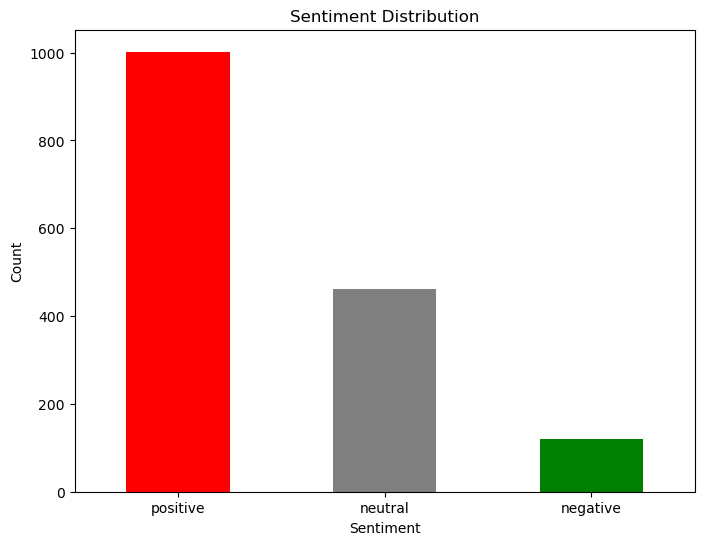


Average and Total Likes/Replies by Sentiment:
                    likesCount           repliesCount        
                          mean       sum         mean     sum
predicted_sentiment                                          
negative               2249.51  269941.0        11.91  1429.0
neutral                1897.45  874723.0         5.74  2648.0
positive                915.13  916960.0         3.13  3137.0

Top 3 Posts by Sentiment:
                                       postUrl  \
1291  https://www.instagram.com/p/C8KtyFivHdL/   
1321  https://www.instagram.com/p/C7r4sDNv4uc/   
1095  https://www.instagram.com/p/C4bdQAQPKoz/   
604   https://www.instagram.com/p/C-TAyjWPhQD/   
39    https://www.instagram.com/p/DB5NYFnRyLm/   
609   https://www.instagram.com/p/C-TAyjWPhQD/   
688   https://www.instagram.com/p/C_m1galOjy3/   
2     https://www.instagram.com/p/DB2iNPPO8kk/   
459   https://www.instagram.com/p/DAJrHKzS6pR/   

                                                   te

In [38]:
import matplotlib.pyplot as plt

# 1. Sentiment Distribution
sentiment_counts = processed_instagram_df['predicted_sentiment'].value_counts()

print("Sentiment Distribution:")
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# 2. Likes and Replies by Sentiment
aggregated_stats = processed_instagram_df.groupby('predicted_sentiment').agg({
    'likesCount': ['mean', 'sum'],
    'repliesCount': ['mean', 'sum']
}).round(2)

print("\nAverage and Total Likes/Replies by Sentiment:")
print(aggregated_stats)

# 3. Top Posts by Sentiment
top_posts = processed_instagram_df.sort_values(by='confidence', ascending=False).groupby('predicted_sentiment').head(3)

print("\nTop 3 Posts by Sentiment:")
print(top_posts[['postUrl', 'text', 'predicted_sentiment', 'confidence']])


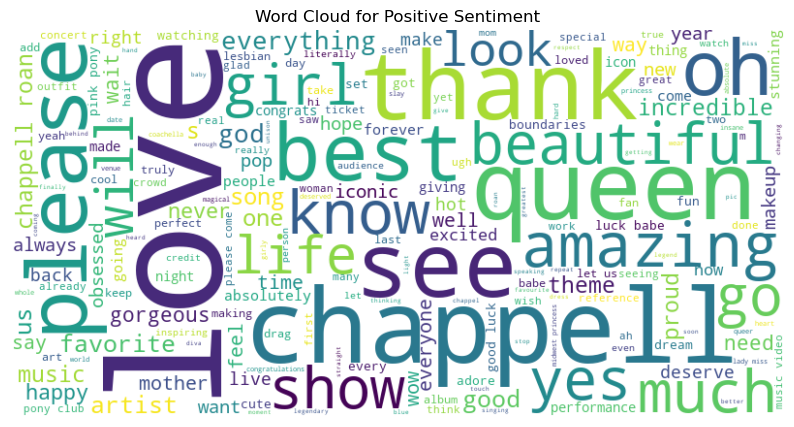

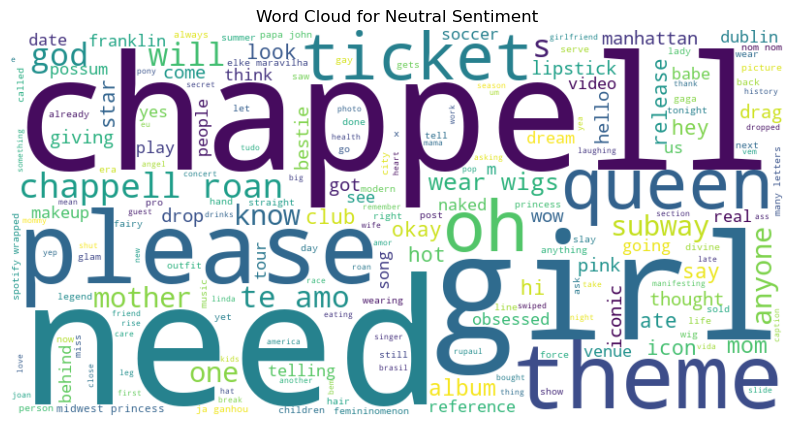

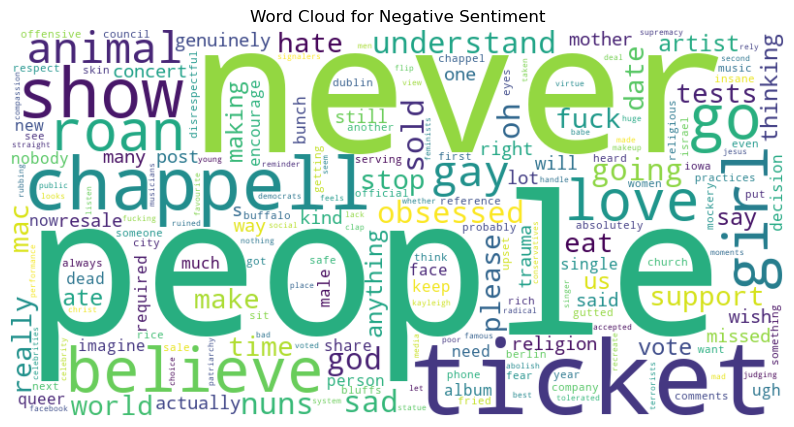

In [39]:
from wordcloud import WordCloud

# Generate word clouds for each sentiment
def generate_wordcloud(sentiment, df, column):
    text = " ".join(df[df['predicted_sentiment'] == sentiment][column].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()

# Generate word clouds for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    generate_wordcloud(sentiment, processed_instagram_df, 'cleaned_text')


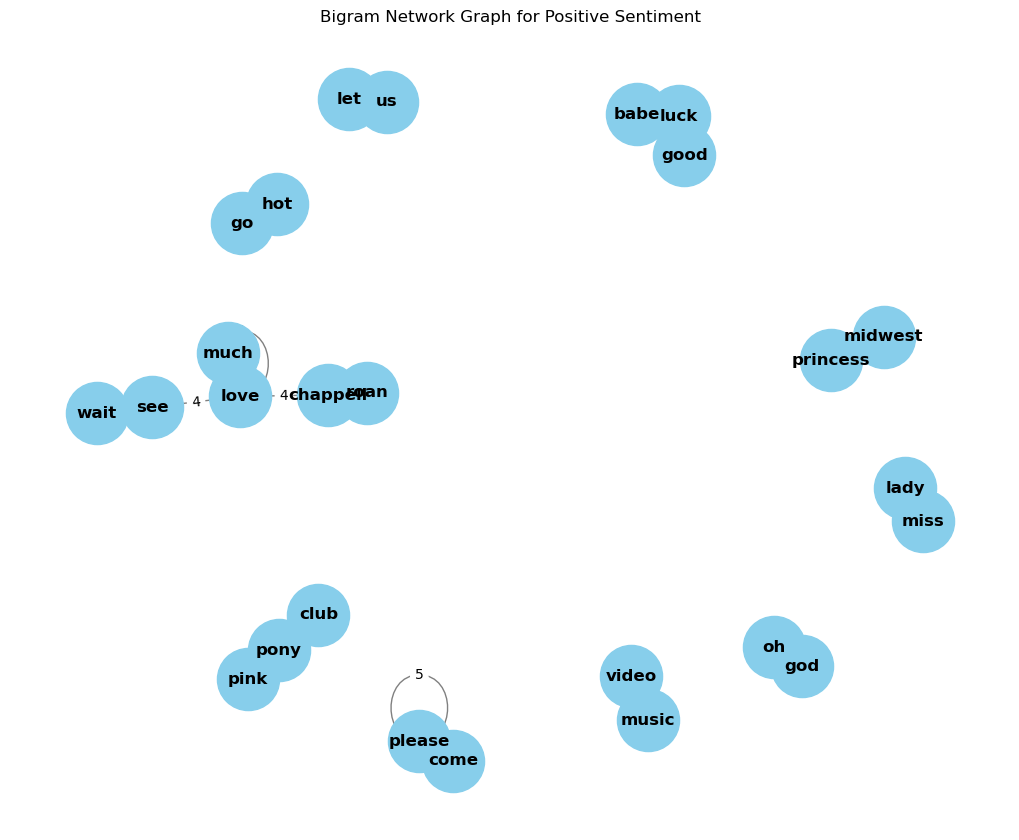

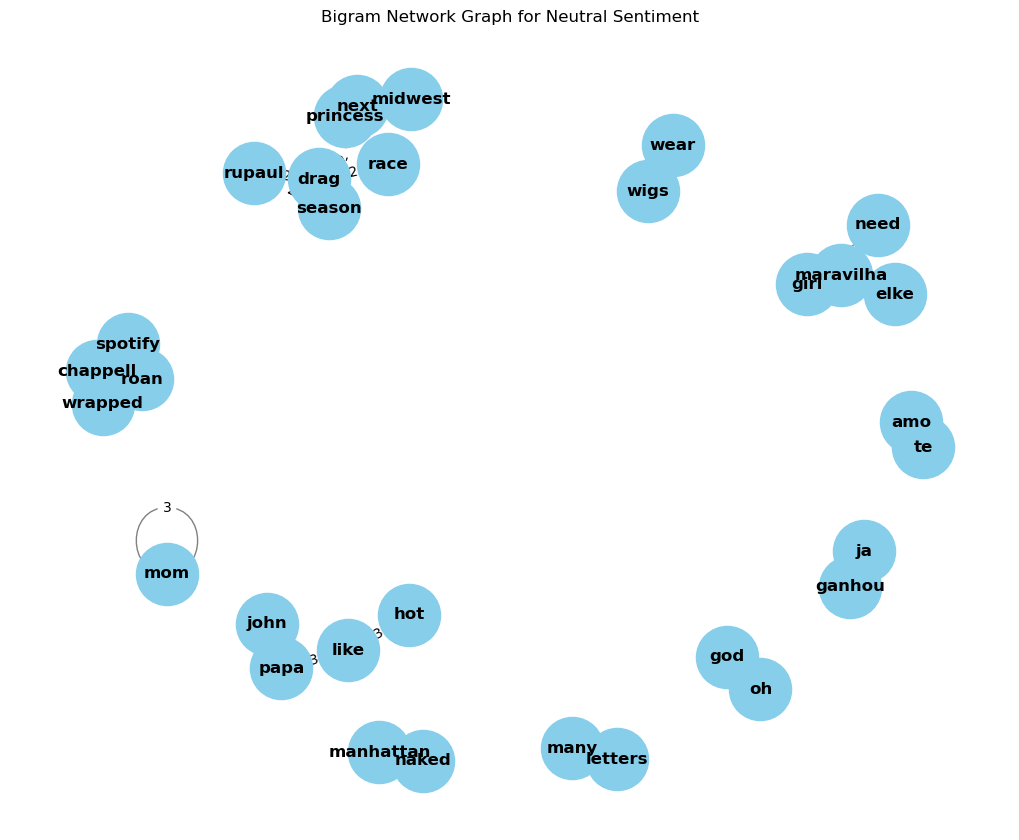

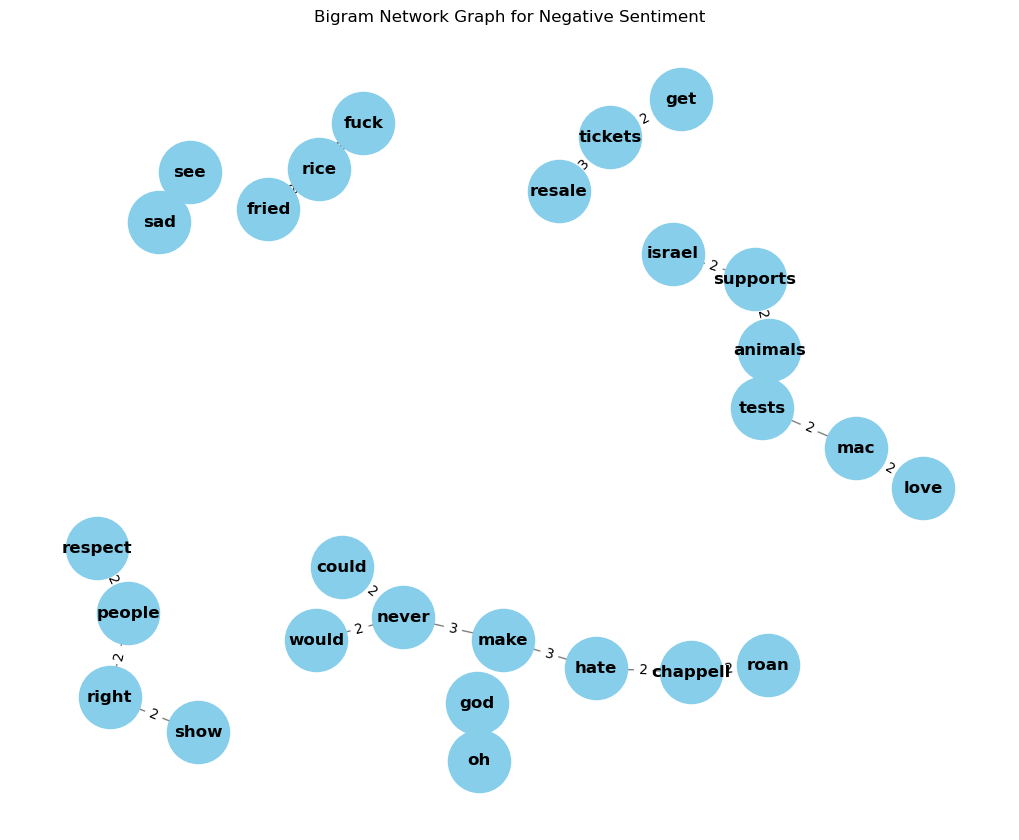

In [42]:
import networkx as nx
from collections import Counter

# Function to generate a bigram network graph
def generate_bigram_graph(df, sentiment, column, top_n=20):
    # Filter bigrams for the specified sentiment
    bigrams = [bigram for bigram_list in df[df['predicted_sentiment'] == sentiment][column].dropna() for bigram in bigram_list]

    bigram_counts = Counter(bigrams).most_common(top_n)

    G = nx.Graph()
    for (word1, word2), count in bigram_counts:
        G.add_edge(word1, word2, weight=count)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(
        G, pos, with_labels=True, node_color='skyblue', edge_color='gray', 
        node_size=2000, font_size=12, font_weight='bold'
    )
    edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f"Bigram Network Graph for {sentiment.capitalize()} Sentiment")
    plt.show()

for sentiment in ['positive', 'neutral', 'negative']:
    generate_bigram_graph(processed_instagram_df, sentiment, 'bigrams')
